# Load NetCDF file

In [56]:
import xarray as xr

# Load SST the NetCDF file
ds = xr.open_dataset('example_SST_dataset.nc')

sst = ds['sea_surface_temperature'].values
lat = ds['lat'].values
lon = ds['lon'].values

# Load Precip the NetCDF file
ds = xr.open_dataset('example_PRECIP_dataset.nc')
precip = ds['precipitation'].values

print(f"Sea Surface Temperature shape: {sst.shape}")
print(f"Precipitation shape: {precip.shape}")
print(f"Latitude shape: {lat.shape}")
print(f"Longitude shape: {lon.shape}")

Sea Surface Temperature shape: (420, 80, 89)
Precipitation shape: (420, 80, 89)
Latitude shape: (80,)
Longitude shape: (89,)


## Compute Anomalies

In [57]:
import copy
import numpy as np

def MOD_anomalia(vetor,lat,lon):
    # calcula a anomalia dos diferentes modelos dentro do vetor
    
    anomalia=copy.deepcopy(vetor)
    
    # Climatologia 
    temp=vetor # shape: (1200,lon,lat)
    end=len(temp)
    mediatemp=copy.deepcopy(temp[0:12,:,:])
    for j in range(12):
        zz=copy.deepcopy(temp[j:end:12,:,:])
        mediatemp[j,:,:]=np.nanmean(zz[:,:,:], axis=0) # vetor com médias/climatologia
        
    #CALCULO DO VETOR ANOMALIA
    for t in range(12):
        anomalia[t:end:12,:,:]=temp[t:end:12,:,:]-mediatemp[t,:,:]
    
    return anomalia

In [58]:
# Creates ocean Mask for sst
mask = ( sst[0,:,:] < -100 )
#Full mask for precip
fullmask = copy.deepcopy(mask)
fullmask[:]=True

for i in range(len(mask)):
    for j in range(len(mask[0])):
        if sst[0,i,j] == 0 or sst[0,i,j] == np.nan:
            mask[i,j] = True
            
sst[:,mask]=np.nan

## CALCULA ANOMALIAS

ssta = MOD_anomalia(sst,lat,lon)
precipa = MOD_anomalia(precip,lat,lon)

## NORMALIZES precip to stand for kg m^-2 s^-1 per month divided by 10.000 - so monthly values are in order O(10) 
precipa = precipa*10e4


/tmp/ipykernel_2963/435290449.py:15: RuntimeWarning: Mean of empty slice
  mediatemp[j,:,:]=np.nanmean(zz[:,:,:], axis=0) # vetor com médias/climatologia


## Applies decadal Filter

In [59]:
def smooth(x,window_len=1,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len//2-1):-(window_len//2)]

In [60]:
## PASSA FILTRO DECADAL
filtro=120
        
for l in range(ssta.shape[1]):
    for ln in range(ssta.shape[2]):
            ssta[:,l,ln]=smooth(ssta[:,l,ln],filtro)
            precipa[:,l,ln]=smooth(precipa[:,l,ln],filtro)

# Principal Component Analysis Decomposition (PCA)

### Precip

In [61]:
### Full PCA
from sklearn.decomposition import PCA

# ESCOLHE APENAS AS 3 PRIMEIRAS COMPONENTES

vetor = precipa[:,:]
xxp = copy.deepcopy(vetor[0:3])
X = vetor.reshape((vetor.shape[0],vetor.shape[1]*vetor.shape[2]))
MASCARA = np.ma.masked_invalid(xxp[0])
X = X[:, ~np.isnan(X).any(axis=0)] # removes nan values from decadal filter
X = np.swapaxes(X,0,1) # X swapts spatial and temporal
MASCARAv = X != np.nan

p=3
pca = PCA(n_components=p)
pca.fit(X)
xp = pca.transform(X)
xp = xp[:,0:p]
xp =  np.swapaxes(xp,0,1)
xxp[0:3,~MASCARA.mask] = xp # componentes, lat,lon

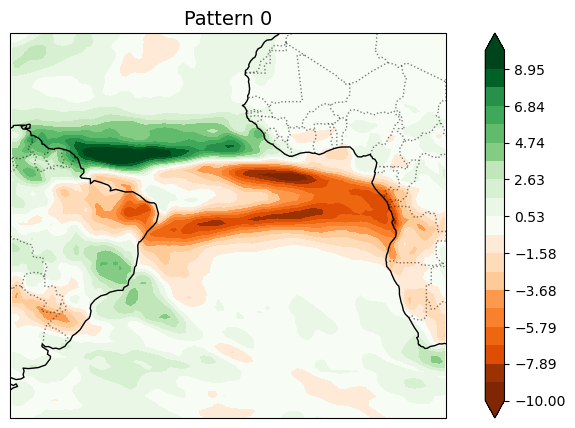

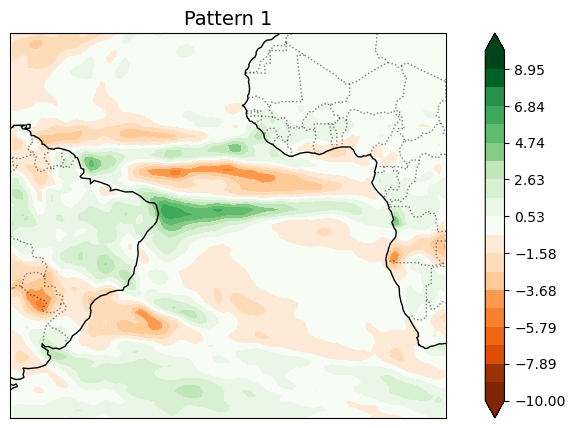

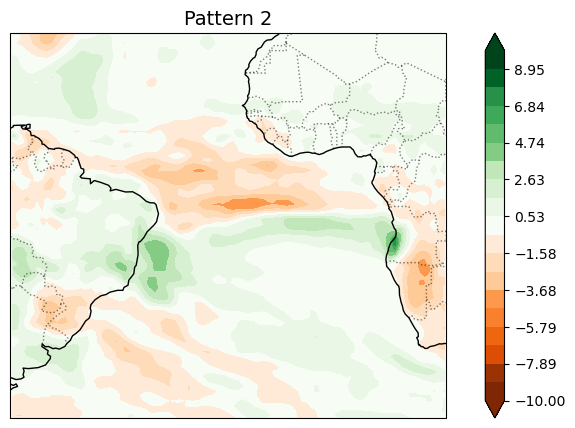

In [62]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features

from matplotlib import cm
from matplotlib.colors import ListedColormap
### CMAP PARA CHUVA ############################
top = cm.get_cmap('Greens', 12)
bottom = cm.get_cmap('Oranges_r', 12)
newcolors = np.vstack((bottom(np.linspace(0, 1, 12)),
                       top(np.linspace(0, 1, 12))))
cmpchuva = ListedColormap(newcolors, name='OrangeGreen')
################################################

for pattern in [0,1,2]:
    plot = np.squeeze(xxp[pattern]).reshape(len(lat),len(lon))

    levelppt = 10
    levelp = np.linspace(-levelppt,levelppt, 20)

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1, 1, 1, aspect='equal',
                         projection=ccrs.PlateCarree(central_longitude=-90.0, globe=None))

    ax.set_extent([-65, 24, -49, 29.5], ccrs.PlateCarree())
    im = ax.contourf(lon, lat, plot,levels=levelp,cmap=cmpchuva,extend='both',transform=ccrs.PlateCarree()) ## MUDAR PARA AZUL E VERMELHO TRADICIONAL cmap='bwr'         
    ax.coastlines(linewidths=1)
    ax.add_feature(cf.BORDERS, linestyle=':', alpha=.5)

    ax.set_title('Pattern '+ str(pattern), fontsize=14)
    plt.colorbar(im)
    

### SST

In [63]:
### Full PCA
from sklearn.decomposition import PCA

# ESCOLHE APENAS AS 3 PRIMEIRAS COMPONENTES

vetor = ssta[:,:]
xxs = copy.deepcopy(vetor[0:3])
X = vetor.reshape((vetor.shape[0],vetor.shape[1]*vetor.shape[2]))
MASCARA = np.ma.masked_invalid(xxs[0])
X = X[:, ~np.isnan(X).any(axis=0)] # removes nan values from decadal filter
X = np.swapaxes(X,0,1) # X swapts spatial and temporal
MASCARAv = X != np.nan

p=3
pca = PCA(n_components=p)
pca.fit(X)
xs = pca.transform(X)
xs = xs[:,0:p]
xs =  np.swapaxes(xs,0,1)
xxs[0:3,~MASCARA.mask] = xs # componentes, lat,lon

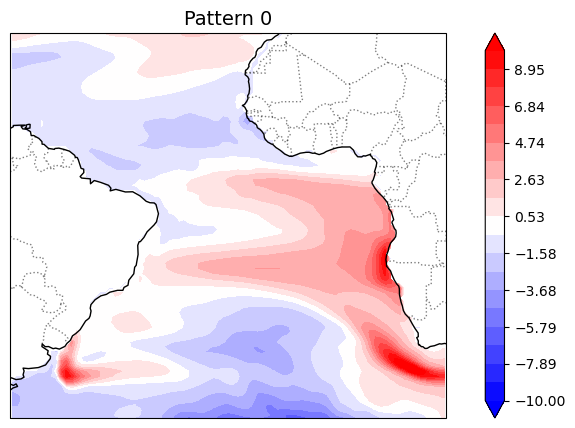

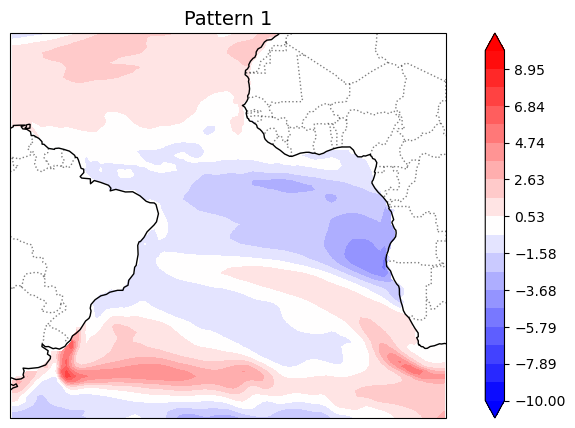

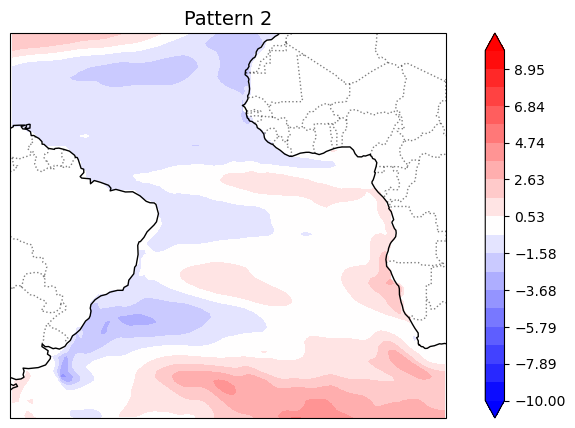

In [64]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features

for pattern in [0,1,2]:
    plot = np.squeeze(xxs[pattern]).reshape(len(lat),len(lon))
    
    levelsst = 10
    levels = np.linspace(-levelsst,levelsst, 20)

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1, 1, 1, aspect='equal',
                         projection=ccrs.PlateCarree(central_longitude=-90.0, globe=None))

    ax.set_extent([-65, 24, -49, 29.5], ccrs.PlateCarree())
    im = ax.contourf(lon, lat, plot,levels=levels,cmap='bwr',extend='both',transform=ccrs.PlateCarree()) ## MUDAR PARA AZUL E VERMELHO TRADICIONAL cmap='bwr'         
    ax.coastlines(linewidths=1)
    ax.add_feature(cf.BORDERS, linestyle=':', alpha=.5)

    ax.set_title('Pattern '+ str(pattern), fontsize=14)
    plt.colorbar(im)

# EOF Monthly Series : Ocean Modes Index and their precipitation counterparts

In [65]:
def PlotSeries(fig, series, color_pos='r',color_neg='b',label_pos=None,label_neg=None,Title=None,start = 0,bottom=False):
    # FUNCAO QUE PLOTA SERIES
    
    #### Linhas constantes de +1 e -1 #
    xx=list(range(0, len(series)))
    x=copy.deepcopy(xx)
    for i in range(len(xx)):
        x[i]=1+(0.5+xx[i])/12
    y=[1]*len(x)
    yy=[-1]*len(x)
    ###################################
    
    plt.fill_between(x, series,
                     where=(series > 0),
                     alpha=0.50, color=color_pos, interpolate=True, label=label_pos)
    plt.fill_between(x, series,
                     where=(series < 0),
                     alpha=0.50, color=color_neg, interpolate=True, label=label_neg)
    
    #fig.title.set_text(Title)
    fig.set_ylabel(Title,fontweight ='bold')
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=bottom,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=bottom) # labels along the bottom edge are off
    if bottom:
        fig.set_xlabel('sim year',fontweight ='bold')
    plt.plot(x[start:len(x)],y[start:len(x)],linestyle=":",color=color_pos,alpha=0.5)
    plt.plot(x[start:len(x)],yy[start:len(x)],linestyle=":",color=color_neg,alpha=0.5)

## sst

In [66]:
# projeta mapas ssta do atlantico nas 3 componentes principais (x), criando indice de cada componente
time_len = ssta.shape[0]
proj1_s, proj2_s, proj3_s = np.ndarray((time_len)),np.ndarray((time_len)),np.ndarray((time_len))
counter = -1

for sst in ssta:
    counter+=1
    sst    = sst[~np.isnan(sst)].reshape(sst[~np.isnan(sst)].shape[0])
    first  = np.squeeze(xxs[0][~np.isnan(xxs[0])]).reshape(sst.shape[0])
    second = np.squeeze(xxs[1][~np.isnan(xxs[0])]).reshape(sst.shape[0])
    third  = np.squeeze(xxs[2][~np.isnan(xxs[0])]).reshape(sst.shape[0])

    proj1_s[counter] = np.inner(sst,first)
    proj2_s[counter] = np.inner(sst,second)
    proj3_s[counter] = np.inner(sst,third)

# Normalizes with standrd deviation
proj1_s = proj1_s/np.std(proj1_s)
proj2_s = proj2_s/np.std(proj2_s)
proj3_s = proj3_s/np.std(proj3_s)


<Figure size 640x480 with 0 Axes>

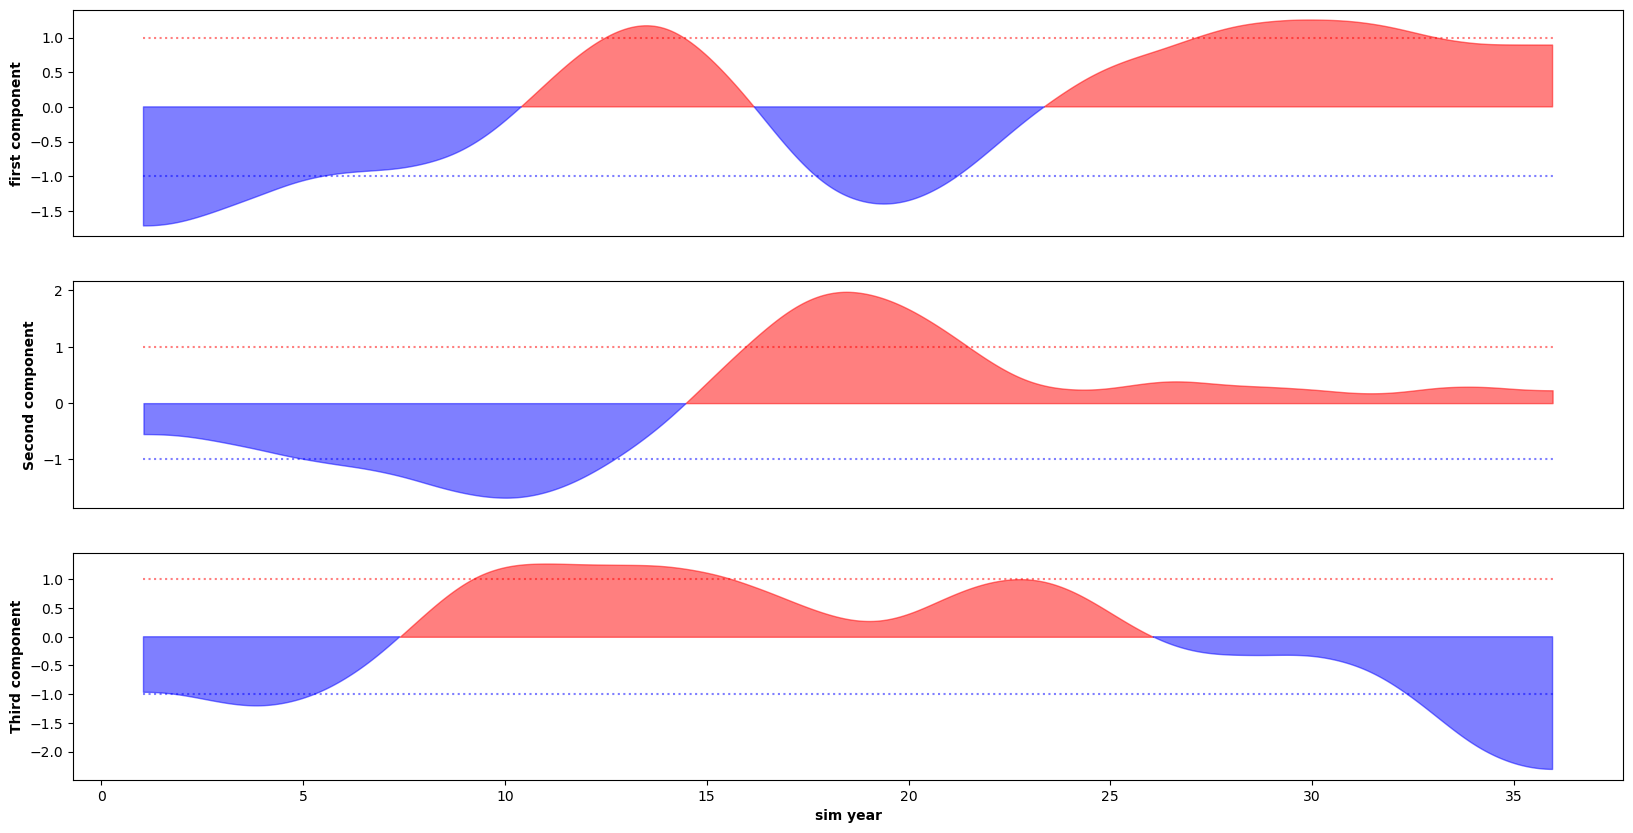

In [67]:
plt.figure()
fig = plt.figure(figsize=(20,5*2))#

a= fig.add_subplot(3, 1,1)
PlotSeries(a, proj1_s,
           label_pos='positive',label_neg='negative',
           Title='first component',start = 0)

a= fig.add_subplot(3, 1,2)
PlotSeries(a, proj2_s,
           label_pos='positive',label_neg='negative',
           Title='Second component',start = 0)

a= fig.add_subplot(3, 1,3)
PlotSeries(a, proj3_s,
           label_pos='positive',label_neg='negative',
           Title='Third component',start = 0,bottom=True)

## precip

In [68]:
# projeta mapas ssta do atlantico nas 3 componentes principais (x), criando indice de cada componente
time_len = precipa.shape[0]
proj1_p, proj2_p, proj3_p = np.ndarray((time_len)),np.ndarray((time_len)),np.ndarray((time_len))
counter = -1

for ppt in precipa:
    counter+=1
    ppt    = ppt[~np.isnan(ppt)].reshape(ppt[~np.isnan(ppt)].shape[0])
    first  = np.squeeze(xxp[0][~np.isnan(xxp[0])]).reshape(ppt.shape[0])
    second = np.squeeze(xxp[1][~np.isnan(xxp[0])]).reshape(ppt.shape[0])
    third  = np.squeeze(xxp[2][~np.isnan(xxp[0])]).reshape(ppt.shape[0])

    proj1_p[counter] = np.inner(ppt,first)
    proj2_p[counter] = np.inner(ppt,second)
    proj3_p[counter] = np.inner(ppt,third)

# Normalizes with standrd deviation
proj1_p = proj1_p/np.std(proj1_p)
proj2_p = proj2_p/np.std(proj2_p)
proj3_p = proj3_p/np.std(proj3_p)


<Figure size 640x480 with 0 Axes>

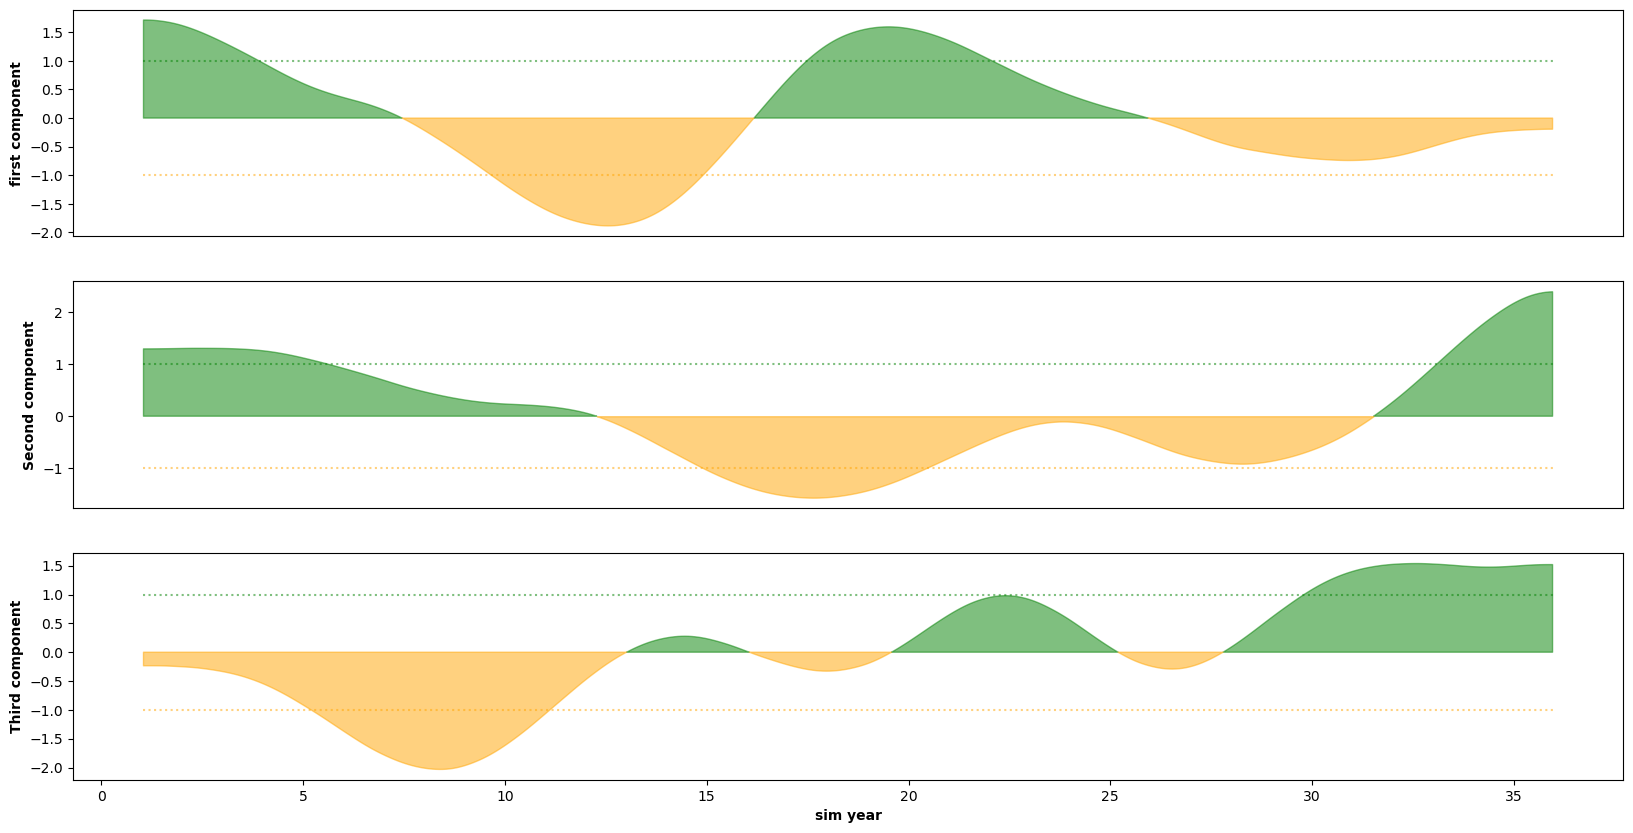

In [69]:
plt.figure()
fig = plt.figure(figsize=(20,5*2))#

a= fig.add_subplot(3, 1,1)
PlotSeries(a, proj1_p,color_pos='green',color_neg='orange',
           label_pos='positive',label_neg='negative',
           Title='first component',start = 0)

a= fig.add_subplot(3, 1,2)
PlotSeries(a, proj2_p,color_pos='green',color_neg='orange',
           label_pos='positive',label_neg='negative',
           Title='Second component',start = 0)

a= fig.add_subplot(3, 1,3)
PlotSeries(a, proj3_p,color_pos='green',color_neg='orange',
           label_pos='positive',label_neg='negative',
           Title='Third component',start = 0,bottom=True)